# Training eines MLPs auf MNIST

## Setup

### Einbinden von Paketen

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

np.__version__, pd.__version__, sklearn.__version__

('1.23.4', '1.5.0', '1.1.3')

## 1. Spielzeugdatensatz

### Aufgabe 1.1

Erzeugen von 200 zweidimensionalen Trainingsdatenpunkten mithilfe einer Gleichverteilung über dem Gebiet `[-6, 6] x [-6, 6]`:

In [87]:
X_train = np.random.uniform(-6,6,(200,2))

### Aufgabe 1.2

Vergabe der Klassenlabels 0 und 1:

In [88]:
def classify_data(data):
  labels = []
  for item in data:
    if (item[0] < 0 and item[1] < 0) or (item[0] > 0 and item[1] > 0):
      labels.append(0)
    else:
      labels.append(1)
  return labels

y_train = classify_data(X_train)

### Aufgabe 1.3

Erzeugen eines gleich großen Testdatensatzes:

In [89]:
X_test = np.random.uniform(-6,6,(200,2))
y_test = classify_data(X_test)

Darstellung der Trainings- und Testdatensätze als Scatterplot:

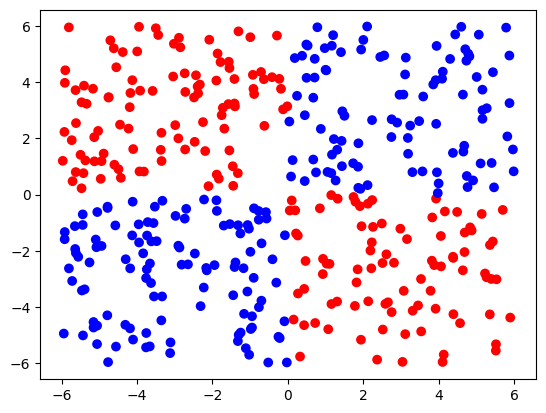

In [90]:
def get_colors(data):
  colors = []
  for y in data:
    if y == 0:
      colors.append('b')
    if y == 1:
      colors.append('r')
  return colors

plt.scatter(X_train[:,0], X_train[:,1], c=get_colors(y_train))
plt.scatter(X_test[:,0], X_test[:,1], c=get_colors(y_test))

### Aufgabe 1.4

Der Gewichtsvektor hat die Form `(2, 1)` weil wir 2 eindimensionale Eingangswerte haben.

In [91]:
weight_1 = np.array([1, 0])
weight_2 = np.array([0, 1])
weights = np.array([weight_1, weight_2])
weight_1.shape

(2,)

### Aufgabe 1.5

Berechnen der Entscheidungsfunktion der beiden Neuronen:

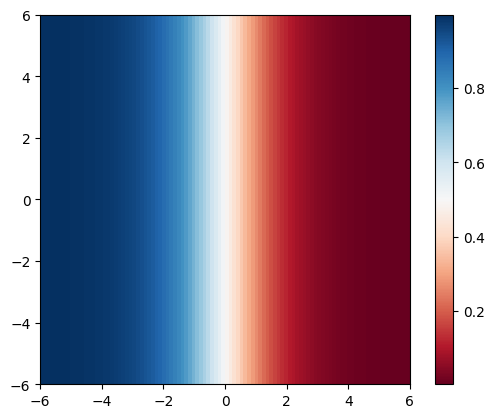

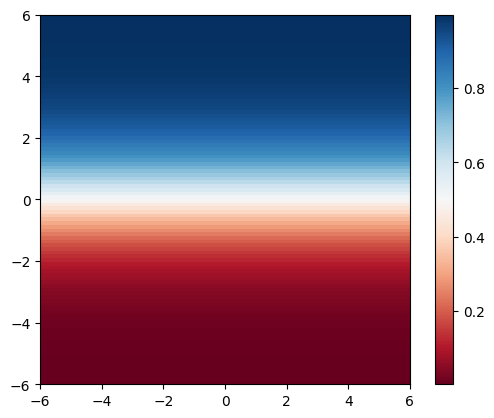

In [92]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

x, y = np.meshgrid(np.linspace(-6, 6, 100), np.linspace(-6, 6, 100))
sigmoid_x = sigmoid(-x)
sigmoid_y = sigmoid(-y)

plt.imshow(sigmoid_x, extent=(-6, 6, -6, 6), cmap='RdBu')
plt.colorbar()
plt.show()
plt.imshow(sigmoid_y, extent=(-6, 6, -6, 6), cmap='RdBu')
plt.colorbar()
plt.show()

### Aufgabe 1.6

Berechnung des Outputs der Eingangsneuronen:

In [93]:
def calc_neuron_output(w, X):
    return sigmoid(np.sum(w.T * X))

neuron_output_train = np.zeros((len(X_train), 2))
for index, x in enumerate(X_train):
    neuron_output_train[index, 0] = calc_neuron_output(weights[0], x)
    neuron_output_train[index, 1] = calc_neuron_output(weights[1], x)

neuron_output_test = np.zeros((len(X_test), 2))
for index, x in enumerate(X_test):
    neuron_output_test[index, 0] = calc_neuron_output(weights[0], x)
    neuron_output_test[index, 1] = calc_neuron_output(weights[1], x)

neuron_output_train[:5,:]

array([[0.00432864, 0.33065739],
       [0.08044858, 0.98597495],
       [0.86610532, 0.55993658],
       [0.15450325, 0.24885536],
       [0.00419655, 0.96412564]])

In [94]:
gitter_output = np.zeros((2, 100*100))
step = 12/100
index = 0
for x in np.arange(-6, 6, step):
    for y in np.arange(-6, 6, step):
        input = np.array([x, y])
        gitter_output[0, index] = calc_neuron_output(weights[0], input)
        gitter_output[1, index] = calc_neuron_output(weights[1], input)
        index += 1

gitter_output

array([[0.00247262, 0.00247262, 0.00247262, ..., 0.997213  , 0.997213  ,
        0.997213  ],
       [0.00247262, 0.002787  , 0.00314121, ..., 0.99645971, 0.99685879,
        0.997213  ]])

## 2. Training eines MLPs auf den Spielzeugdaten

### Aufgabe 2.1

Festlegen der Trainingsparameter:

In [95]:
mbs = 10                                        # Größe der Minibatches
eta = 3.0                                       # Lernrate
no_hidden_1 = 2                                 # Anzahl versteckter Neuronen
no_hidden_2 = 2                                 # Anzahl versteckter Neuronen
epochs = 150                                    # Anzahl Epochen
sizes = [2, no_hidden_1, no_hidden_2, 1]        # Vierschichtiges MPL mit 2 Eingangs-, 2x2 versteckten und 1 Ausgangsneuronen
num_layers = len(sizes)                         # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
print(weights[1].shape)

(2, 2)


### Aufgabe 2.2

Erstellen aller benötigten Funktionen zum Training:

In [96]:
# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    # return (output_activations-y)
    return np.nan_to_num((1-y)/(1-output_activations)-y/output_activations)

def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

from sklearn.metrics import mean_squared_error

def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    y_array = []
    y_pred_array = []
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    
    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        y_pred = feedforward(x)
        y_pred_array.append(y_pred[0])
        y_array.append(y[0])
        
        if y <= 0.5:
          c = 0
        else:
          c = 1
        
        if y_pred <= 0.5:
          c_pred = 0
        else:
          c_pred = 1
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if c == c_pred:
            correct += 1

    mse = np.nan_to_num(mean_squared_error(y_array, y_pred_array))
        
    return correct, mse

def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    mse = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
          
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j], mse[j] = evaluate(x2, y2)
        print("Epoch {0}: {1} / {2}".format(j, acc_val[j], n_test))
    
    return acc_val, mse

### Aufgabe 2.3

Trainineren des Netzes:

In [97]:
y_train_reshaped = np.reshape(y_train,(200,1))
y_test_reshaped = np.reshape(y_test,(200,1))

acc_val, mse = SGD(neuron_output_train, y_train_reshaped, epochs, mbs, eta, neuron_output_test, y_test_reshaped)

Epoch 0: 95.0 / 200
Epoch 1: 105.0 / 200
Epoch 2: 105.0 / 200
Epoch 3: 105.0 / 200
Epoch 4: 105.0 / 200
Epoch 5: 95.0 / 200
Epoch 6: 95.0 / 200
Epoch 7: 105.0 / 200
Epoch 8: 105.0 / 200
Epoch 9: 105.0 / 200
Epoch 10: 105.0 / 200
Epoch 11: 95.0 / 200
Epoch 12: 95.0 / 200
Epoch 13: 105.0 / 200
Epoch 14: 105.0 / 200
Epoch 15: 105.0 / 200
Epoch 16: 105.0 / 200
Epoch 17: 105.0 / 200
Epoch 18: 95.0 / 200
Epoch 19: 95.0 / 200
Epoch 20: 156.0 / 200
Epoch 21: 109.0 / 200
Epoch 22: 105.0 / 200
Epoch 23: 146.0 / 200
Epoch 24: 153.0 / 200
Epoch 25: 154.0 / 200
Epoch 26: 152.0 / 200
Epoch 27: 155.0 / 200
Epoch 28: 146.0 / 200
Epoch 29: 149.0 / 200
Epoch 30: 147.0 / 200
Epoch 31: 151.0 / 200
Epoch 32: 148.0 / 200
Epoch 33: 155.0 / 200
Epoch 34: 154.0 / 200
Epoch 35: 151.0 / 200
Epoch 36: 157.0 / 200
Epoch 37: 155.0 / 200
Epoch 38: 148.0 / 200
Epoch 39: 154.0 / 200
Epoch 40: 157.0 / 200
Epoch 41: 151.0 / 200
Epoch 42: 157.0 / 200
Epoch 43: 158.0 / 200
Epoch 44: 157.0 / 200
Epoch 45: 155.0 / 200
Epoch

Darstellung der Lernkurve für Genauigkeit:

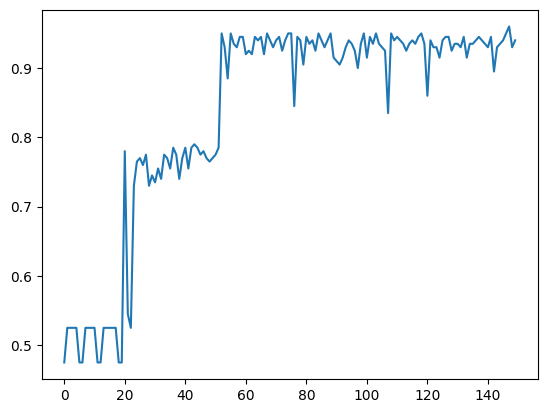

In [98]:
plt.plot(acc_val/neuron_output_test.shape[0])

Darstellung der Lernkurve für MSE:

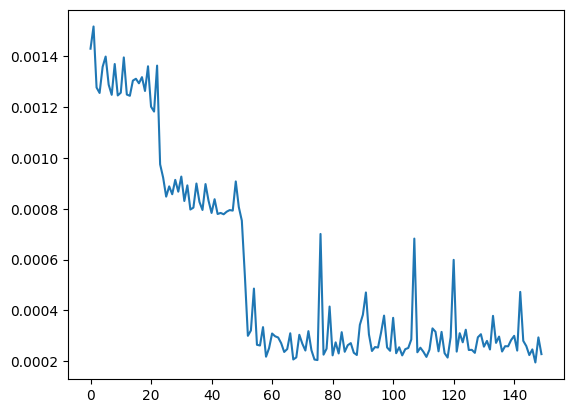

In [99]:
plt.plot(mse/neuron_output_test.shape[0])